#  Water Body Semantic Segmentation
### 12-band Multispectral Satellite Pipeline via `geoai`

**Architecture:** U-Net with ResNet34 encoder (pretrained ImageNet, via `smp`)  
**Data:** 12-band GeoTIFF images + binary water masks  
**Library:** [`geoai`](https://github.com/opengeos/geoai) — production-grade geospatial deep learning  

> `geoai` wraps `segmentation-models-pytorch` with sliding-window inference,  
> training history, and geospatial I/O — the right tool for satellite segmentation.

##  Install Packages

In [36]:
%pip install geoai-py rasterio -q

##  Import Libraries

In [37]:
import os
import geoai
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

print(f"geoai version : {geoai.__version__}")

geoai version : 0.29.1


##  Mount Google Drive & Locate My Data

In [38]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!unzip "/content/drive/MyDrive/satellite_data.zip" -d "/content/satellite_data"

Archive:  /content/drive/MyDrive/satellite_data.zip
replace /content/satellite_data/data/images/2.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [40]:


IMAGES_DIR = '/content/satellite_data/data/images'   # 12-band GeoTIFFs
LABELS_DIR = '/content/satellite_data/data/labels'   # binary masks (0/255 or 0/1)
OUTPUT_DIR = '/content/satellite_data/unet_models'

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

images = sorted([f for f in os.listdir(IMAGES_DIR) if f.endswith('.tif')])
labels = sorted([f for f in os.listdir(LABELS_DIR) if f.endswith(('.png','.tif'))])
print(f"v   Found {len(images)} images and {len(labels)} labels")
print(f"   Sample images : {images[:3]}")
print(f"   Sample labels : {labels[:3]}")

v   Found 306 images and 456 labels
   Sample images : ['0.tif', '1.tif', '10.tif']
   Sample labels : ['0.png', '1.png', '10.png']


In [41]:
from pathlib import Path

img_stems = {p.stem for p in Path(IMAGES_DIR).glob('*.tif')}
lbl_stems = {p.stem for p in Path(LABELS_DIR).glob('*.png') if '_' not in p.stem}

print(f"Images   : {len(img_stems)}")
print(f"Labels   : {len(lbl_stems)}")
print(f"Matched  : {len(img_stems & lbl_stems)}")
print(f"Imgs without label: {sorted(img_stems - lbl_stems)[:5]}")
print(f"Lbls without image: {sorted(lbl_stems - img_stems)[:5]}")

Images   : 306
Labels   : 306
Matched  : 306
Imgs without label: []
Lbls without image: []


##  Inspect a Sample Image

Check band count, spatial size, and mask values before training.

In [42]:
import rasterio
from pathlib import Path
import glob

print("=== IMAGE FILES (first 10) ===")
img_files = sorted(Path(IMAGES_DIR).glob('*'))[:10]
for f in img_files:
    print(f"  {f.name}  (suffix={f.suffix})")

print()
print("=== LABEL FILES (first 10) ===")
lbl_files = sorted(Path(LABELS_DIR).glob('*'))[:10]
for f in lbl_files:
    print(f"  {f.name}  (suffix={f.suffix})")


all_images = sorted(Path(IMAGES_DIR).glob('*.tif'))
matched, unmatched = [], []
for img in all_images:
    candidates = list(Path(LABELS_DIR).glob(f'{img.stem}.*'))

    exact = [c for c in candidates if c.stem == img.stem]
    if exact:
        matched.append((img.name, exact[0].name))
    else:
        unmatched.append(img.name)

print()
print(f"  Matched   : {len(matched)}")
print(f"  Unmatched : {len(unmatched)}")
if unmatched:
    print(f"  First few unmatched: {unmatched[:5]}")
if matched:
    print(f"  First few matched  : {matched[:5]}")


=== IMAGE FILES (first 10) ===
  0.tif  (suffix=.tif)
  1.tif  (suffix=.tif)
  10.tif  (suffix=.tif)
  100.tif  (suffix=.tif)
  101.tif  (suffix=.tif)
  102.tif  (suffix=.tif)
  103.tif  (suffix=.tif)
  104.tif  (suffix=.tif)
  105.tif  (suffix=.tif)
  106.tif  (suffix=.tif)

=== LABEL FILES (first 10) ===
  0.png  (suffix=.png)
  1.png  (suffix=.png)
  10.png  (suffix=.png)
  100.png  (suffix=.png)
  100_184.png  (suffix=.png)
  101.png  (suffix=.png)
  101_89.png  (suffix=.png)
  102.png  (suffix=.png)
  102_179.png  (suffix=.png)
  103.png  (suffix=.png)

  Matched   : 306
  Unmatched : 0
  First few matched  : [('0.tif', '0.png'), ('1.tif', '1.png'), ('10.tif', '10.png'), ('100.tif', '100.png'), ('101.tif', '101.png')]


In [43]:
import shutil
from pathlib import Path

IMAGES_CLEAN = '/content/satellite_data/images_clean'
LABELS_CLEAN = '/content/satellite_data/labels_clean'
Path(IMAGES_CLEAN).mkdir(parents=True, exist_ok=True)
Path(LABELS_CLEAN).mkdir(parents=True, exist_ok=True)

copied = 0
skipped = 0

for img_path in sorted(Path(IMAGES_DIR).glob('*.tif')):
    # Find label with exact same stem (e.g. '42.png' for '42.tif')
    candidates = [f for f in Path(LABELS_DIR).glob(f'{img_path.stem}.*')
                  if f.stem == img_path.stem]
    if not candidates:
        skipped += 1
        continue

    lbl_path = candidates[0]


    shutil.copy2(img_path, Path(IMAGES_CLEAN) / img_path.name)


    dst_lbl = Path(LABELS_CLEAN) / f'{img_path.stem}.png'
    shutil.copy2(lbl_path, dst_lbl)
    copied += 1

print(f"   Copied {copied} image-label pairs to clean directories")
print(f"   Skipped {skipped} images with no matching label")
print(f"   Images dir : {IMAGES_CLEAN}")
print(f"   Labels dir : {LABELS_CLEAN}")

# Verify mask values in one sample
import numpy as np
sample_lbl = sorted(Path(LABELS_CLEAN).glob('*.png'))[0]
with rasterio.open(sample_lbl) as src:
    arr = src.read(1)
print(f"\nSample mask unique values: {np.unique(arr)}  ← binarizing to 0/1 next")

# geoai expects masks as 0=background, 1..N=classes.
# If your masks are 0/255, binarize them in-place now.
'''if arr.max() > 1:
    print("Masks are 0/255 — binarizing all labels to 0/1...")
    import cv2
    for lbl_f in Path(LABELS_CLEAN).glob('*.png'):
        mask = cv2.imread(str(lbl_f), cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype('uint8')  # 0 or 1
        cv2.imwrite(str(lbl_f), mask)
    print(" All masks binarized to {0, 1}")
else:
    print("Masks already binary ")'''


   Copied 306 image-label pairs to clean directories
   Skipped 0 images with no matching label
   Images dir : /content/satellite_data/images_clean
   Labels dir : /content/satellite_data/labels_clean

Sample mask unique values: [0 1]  ← binarizing to 0/1 next


'if arr.max() > 1:\n    print("Masks are 0/255 — binarizing all labels to 0/1...")\n    import cv2\n    for lbl_f in Path(LABELS_CLEAN).glob(\'*.png\'):\n        mask = cv2.imread(str(lbl_f), cv2.IMREAD_GRAYSCALE)\n        mask = (mask > 0).astype(\'uint8\')  # 0 or 1\n        cv2.imwrite(str(lbl_f), mask)\n    print(" All masks binarized to {0, 1}")\nelse:\n    print("Masks already binary ")'

## Train Segmentation Model

`geoai.train_segmentation_model` handles:
- Train / val split
- Per-band normalisation from training stats only
- `smp` U-Net with ResNet34 encoder (pretrained ImageNet, stem adapted to `num_channels`)
- Dice + BCE combined loss
- Best model checkpoint
- Full training history saved to disk

In [44]:
geoai.train_segmentation_model(
    images_dir      = IMAGES_CLEAN,
    labels_dir      = LABELS_CLEAN,
    output_dir      = OUTPUT_DIR,

    # ── Architecture ──────────────────────────────────────────────────────────
    architecture    = "unet",
    encoder_name    = "resnet34",
    encoder_weights = "imagenet",

    # ── Input ─────────────────────────────────────────────────────────────────
    num_channels    = 12,              # all 12 bands — smp adapts stem conv
    num_classes     = 2,               # 0=background, 1=water

    # ── Training ──────────────────────────────────────────────────────────────
    batch_size      = 8,
    num_epochs      = 50,
    learning_rate   = 1e-3,
    val_split       = 0.2,

    verbose         = True,
)


Using device: cuda
Found 306 image files and 306 label files
Training on 244 images, validating on 62 images
Checking image sizes for compatibility...
All sampled images have the same size: (128, 128)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with unet + resnet34
Model parameters: 24,464,738
Epoch: 1, Batch: 1/31, Loss: 0.5265, Time: 2.11s
Epoch: 1, Batch: 11/31, Loss: 0.5197, Time: 1.72s
Epoch: 1, Batch: 21/31, Loss: 0.6020, Time: 1.33s
Epoch: 1, Batch: 31/31, Loss: 0.5710, Time: 0.67s
Epoch 1/50: Train Loss: 0.5166, Val Loss: 71.9421, Val IoU: 0.1802, Val F1: 0.2676, Val Precision: 0.5059, Val Recall: 0.4113
Saving best model with IoU: 0.1802
Epoch: 2, Batch: 1/31, Loss: 0.3434, Time: 1.67s
Epoch: 2, Batch: 11/31, Loss: 0.2530, Time: 1.45s
Epoch: 2, Batch: 21/31, Loss: 0.2459, Time: 0.86s
Epoch: 2, Batch: 31/31, Loss: 0.6258, Time: 0.77s
Epoch 2/50: Train Loss: 0.4051, Val Loss: 0.6074, Val IoU: 0.6147, Val F1: 0.6780, Val Precision: 0.7947

##  Training Curves

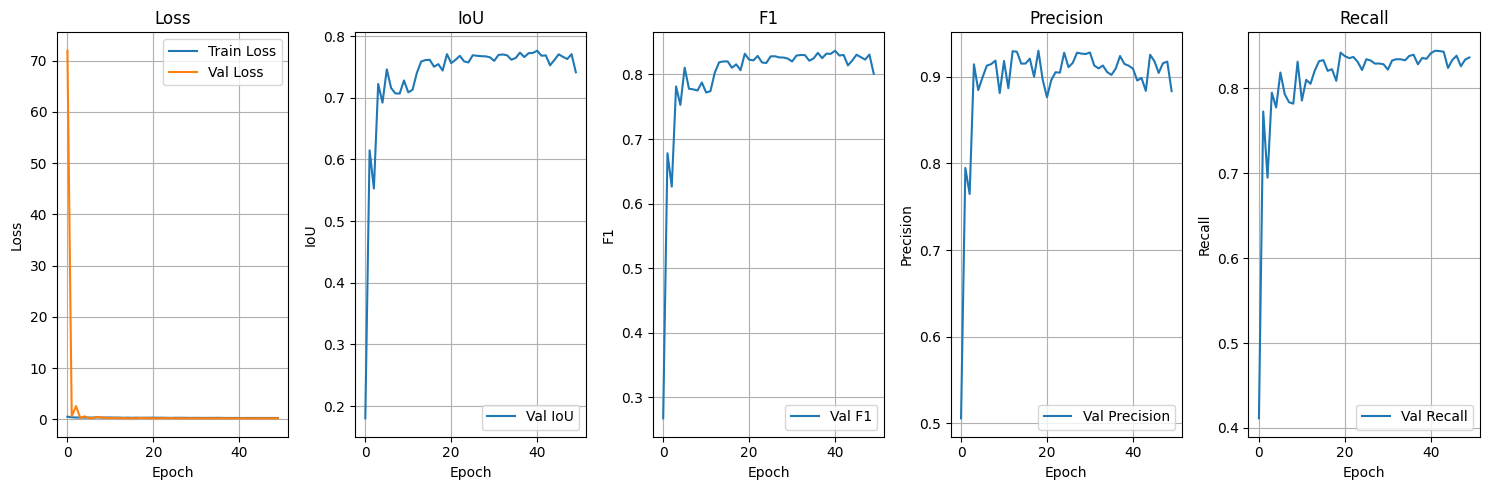


=== Performance Metrics Summary ===
IoU     - Best: 0.7762 | Final: 0.7412
F1      - Best: 0.8367 | Final: 0.8010
Precision - Best: 0.9298 | Final: 0.8833
Recall  - Best: 0.8439 | Final: 0.8360
Val Loss - Best: 0.2003 | Final: 0.2126



,epoch,train_loss,val_loss,val_iou,val_f1,val_precision,val_recall
0,1,0.516602,71.942136,0.180215,0.267607,0.505877,0.411349
1,2,0.405093,0.607449,0.614660,0.677959,0.794661,0.772410
2,3,0.362725,2.585577,0.552755,0.626362,0.764573,0.694525
3,4,0.356598,0.249708,0.722284,0.781371,0.914173,0.794489
4,5,0.349087,0.588952,0.691916,0.752777,0.884469,0.777151
5,6,0.352972,0.243420,0.745995,0.810386,0.899160,0.818262
6,7,0.349254,0.275664,0.715766,0.777903,0.912693,0.792894
7,8,0.393548,0.462112,0.706866,0.776811,0.914350,0.783332
8,9,0.346698,0.380137,0.706753,0.775176,0.918449,0.781636
9,10,0.365816,0.263211,0.727913,0.787412,0.881001,0.831039


In [45]:
geoai.plot_performance_metrics(
    history_path = f"{OUTPUT_DIR}/training_history.pth",
    figsize      = (15, 5),
    verbose      = True,
)

##  Run Inference

`geoai.semantic_segmentation` uses **sliding-window inference** with overlap  
to handle images of any size — no memory issues on large GeoTIFFs.

In [46]:
TEST_IDX  = 3
clean_imgs = sorted(Path(IMAGES_CLEAN).glob('*.tif'))
clean_lbls = sorted(Path(LABELS_CLEAN).glob('*.png'))

test_image_path   = str(clean_imgs[TEST_IDX])
ground_truth_path = str(clean_lbls[TEST_IDX])
model_path        = f"{OUTPUT_DIR}/best_model.pth"

PRED_DIR = '/content/satellite_data/predictions'
Path(PRED_DIR).mkdir(parents=True, exist_ok=True)
prediction_path = f"{PRED_DIR}/pred_{clean_imgs[TEST_IDX].stem}.png"

geoai.semantic_segmentation(
    input_path   = test_image_path,
    output_path  = prediction_path,
    model_path   = model_path,
    architecture = "unet",
    encoder_name = "resnet34",
    num_channels = 12,
    num_classes  = 2,
    window_size  = 128,
    overlap      = 32,
    batch_size   = 4,
)
print(f" Prediction saved → {prediction_path}")


Input file format: GeoTIFF (.tif)
Processing 1 windows...


4it [00:00, 242.39it/s]              

Predicted classes: 2 classes, Background: 70.4%
Inference completed in 0.02 seconds
Saved prediction to /content/satellite_data/predictions/pred_100.png
 Prediction saved → /content/satellite_data/predictions/pred_100.png


##  Visualize Results

Plot saved to: /content/satellite_data/predictions/comparison_3.png


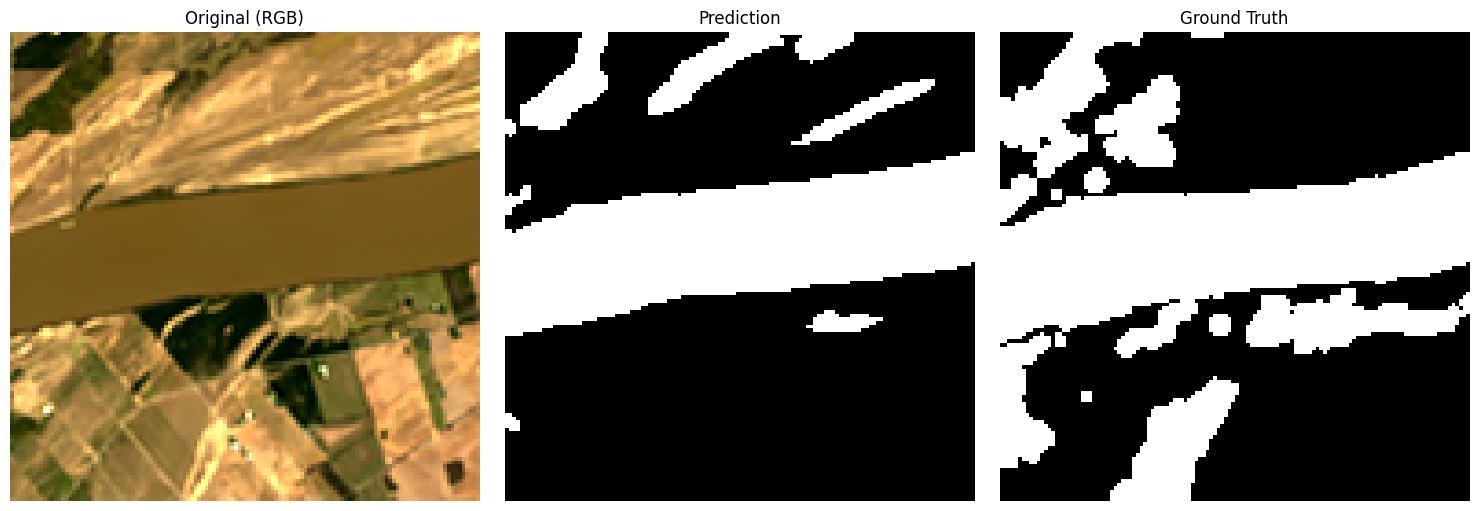

In [47]:
with rasterio.open(test_image_path) as src:
    img = src.read().astype('float32')

rgb = np.stack([img[3], img[2], img[1]], axis=-1)
rgb = (rgb - np.percentile(rgb, 2)) / (np.percentile(rgb, 98) - np.percentile(rgb, 2) + 1e-6)
rgb = np.clip(rgb, 0, 1)

fig = geoai.plot_prediction_comparison(
    original_image     = rgb,
    prediction_image   = prediction_path,
    ground_truth_image = ground_truth_path,
    titles             = ["Original (RGB)", "Prediction", "Ground Truth"],
    figsize            = (15, 5),
    save_path          = f"{PRED_DIR}/comparison_{TEST_IDX}.png",
    show_plot          = True,
)

##  Batch Evaluation on All Test Images

Compute IoU and Dice across the full dataset to get reliable metrics.

  Mean Dice : 0.4983 ± 0.3896
  Mean IoU  : 0.4232 ± 0.3560
  Min  IoU  : 0.0000
  Max  IoU  : 0.9939


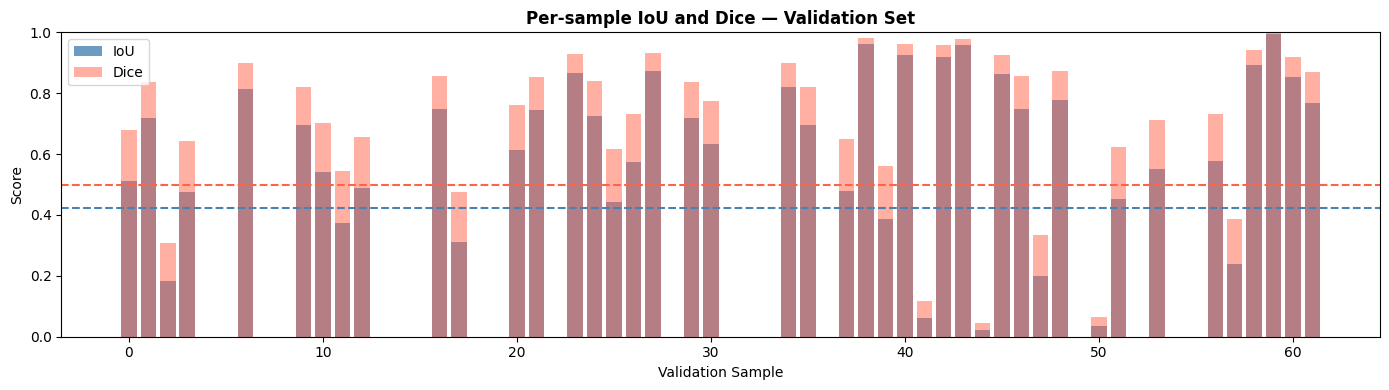

In [48]:
from sklearn.model_selection import train_test_split
import numpy as np

clean_imgs = sorted(Path(IMAGES_CLEAN).glob('*.tif'))
clean_lbls = sorted(Path(LABELS_CLEAN).glob('*.png'))

# Reproduce same split geoai used (random_state=42 is geoai default)
_, val_imgs = train_test_split(clean_imgs, test_size=0.2, random_state=42)
_, val_lbls = train_test_split(clean_lbls, test_size=0.2, random_state=42)

dice_scores, iou_scores = [], []

for img_path, lbl_path in zip(val_imgs, val_lbls):
    pred_path = f"{PRED_DIR}/pred_{img_path.stem}.png"

    if not os.path.exists(pred_path):
        geoai.semantic_segmentation(
            input_path   = str(img_path),
            output_path  = pred_path,
            model_path   = model_path,
            architecture = "unet",
            encoder_name = "resnet34",
            num_channels = 12,
            num_classes  = 2,
            window_size  = 128,
            overlap      = 32,
            batch_size   = 4,
        )

    with rasterio.open(pred_path) as src:
        pred = (src.read(1) > 0).astype('float32')
    with rasterio.open(str(lbl_path)) as src:
        true = (src.read(1) > 0).astype('float32')

    inter = (pred * true).sum()
    union = pred.sum() + true.sum() - inter
    dice_scores.append((2 * inter) / (pred.sum() + true.sum() + 1e-7))
    iou_scores.append(inter / (union + 1e-7))

print(f"  Mean Dice : {np.mean(dice_scores):.4f} ± {np.std(dice_scores):.4f}")
print(f"  Mean IoU  : {np.mean(iou_scores):.4f} ± {np.std(iou_scores):.4f}")
print(f"  Min  IoU  : {np.min(iou_scores):.4f}")
print(f"  Max  IoU  : {np.max(iou_scores):.4f}")


fig, ax = plt.subplots(figsize=(14, 4))
x = range(len(iou_scores))
ax.bar(x, iou_scores,  color='steelblue', alpha=0.8, label='IoU')
ax.bar(x, dice_scores, color='tomato',    alpha=0.5, label='Dice')
ax.axhline(np.mean(iou_scores),  color='steelblue', linestyle='--', linewidth=1.5)
ax.axhline(np.mean(dice_scores), color='tomato',    linestyle='--', linewidth=1.5)
ax.set_xlabel('Validation Sample')
ax.set_ylabel('Score')
ax.set_title('Per-sample IoU and Dice — Validation Set', fontweight='bold')
ax.legend()
ax.set_ylim(0, 1)
plt.tight_layout()
plt.savefig('val_metrics.png', dpi=150)
plt.show()


##  Experiment: Try Other Architectures

`geoai` supports the full `smp` architecture zoo — swap and compare with one line.

In [49]:
# Uncomment whichever you want to try — all use the same 12-band input
# and the same training loop, so results are directly comparable.
EXPERIMENTS = [
    # ("unet",        "resnet34",        "imagenet"),   # ← already trained above
     ("unet",        "resnet50",        "imagenet"),   # deeper encoder
    # ("unetplusplus","resnet34",        "imagenet"),   # nested skip connections
    # ("fpn",         "resnet34",        "imagenet"),   # feature pyramid
    # ("deeplabv3plus","resnet34",       "imagenet"),   # atrous convolutions
    # ("manet",       "resnet34",        "imagenet"),   # multi-scale attention
]

for arch, enc, weights in EXPERIMENTS:
    run_dir = f"{OUTPUT_DIR}/{arch}_{enc}"
    print(f"\nTraining {arch} / {enc}...")
    geoai.train_segmentation_model(
        images_dir      = IMAGES_CLEAN,
        labels_dir      = LABELS_CLEAN,
        output_dir      = run_dir,
        architecture    = arch,
        encoder_name    = enc,
        encoder_weights = weights,
        num_channels    = 12,
        num_classes     = 2,
        batch_size      = 8,
        num_epochs      = 50,
        learning_rate   = 1e-3,
        val_split       = 0.2,
        verbose         = False,
    )
    print(f"  Done → {run_dir}")


Training unet / resnet50...
Using device: cuda
Found 306 image files and 306 label files
Training on 244 images, validating on 62 images
Checking image sizes for compatibility...
All sampled images have the same size: (128, 128)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with unet + resnet50
Model parameters: 32,549,474
Epoch 1/50: Train Loss: 0.4881, Val Loss: 0.8184, Val IoU: 0.6722, Val F1: 0.7354, Val Precision: 0.8283, Val Recall: 0.8014
Saving best model with IoU: 0.6722
Epoch 2/50: Train Loss: 0.3764, Val Loss: 0.3818, Val IoU: 0.6345, Val F1: 0.7000, Val Precision: 0.8579, Val Recall: 0.7535
Epoch 3/50: Train Loss: 0.3896, Val Loss: 0.3996, Val IoU: 0.5961, Val F1: 0.6714, Val Precision: 0.7318, Val Recall: 0.7801
Epoch 4/50: Train Loss: 0.3793, Val Loss: 0.3080, Val IoU: 0.6872, Val F1: 0.7465, Val Precision: 0.9101, Val Recall: 0.7644
Saving best model with IoU: 0.6872
Epoch 5/50: Train Loss: 0.3423, Val Loss: 0.4557, Val IoU: 0.646

In [50]:
EXPERIMENTS = [
    # ("unet",        "resnet34",        "imagenet"),   # ← already trained above
     #("unet",        "resnet50",        "imagenet"),   # deeper encoder
    # ("unetplusplus","resnet34",        "imagenet"),   # nested skip connections
     ("fpn",         "resnet34",        "imagenet"),   # feature pyramid
     #("deeplabv3plus","resnet34",       "imagenet"),   # atrous convolutions
    # ("manet",       "resnet34",        "imagenet"),   # multi-scale attention
]

for arch, enc, weights in EXPERIMENTS:
    run_dir = f"{OUTPUT_DIR}/{arch}_{enc}"
    print(f"\nTraining {arch} / {enc}...")
    geoai.train_segmentation_model(
        images_dir      = IMAGES_CLEAN,
        labels_dir      = LABELS_CLEAN,
        output_dir      = run_dir,
        architecture    = arch,
        encoder_name    = enc,
        encoder_weights = weights,
        num_channels    = 12,
        num_classes     = 2,
        batch_size      = 16,
        num_epochs      = 50,
        learning_rate   = 1e-3,
        val_split       = 0.2,
        verbose         = False,
    )
    print(f"   Done → {run_dir}")


Training fpn / resnet34...
Using device: cuda
Found 306 image files and 306 label files
Training on 244 images, validating on 62 images
Checking image sizes for compatibility...
All sampled images have the same size: (128, 128)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with fpn + resnet34
Model parameters: 23,183,746
Epoch 1/50: Train Loss: 1.2083, Val Loss: 0.4351, Val IoU: 0.5557, Val F1: 0.6012, Val Precision: 0.8195, Val Recall: 0.6583
Saving best model with IoU: 0.5557
Epoch 2/50: Train Loss: 0.5634, Val Loss: 0.3112, Val IoU: 0.6508, Val F1: 0.7044, Val Precision: 0.8858, Val Recall: 0.7362
Saving best model with IoU: 0.6508
Epoch 3/50: Train Loss: 0.4827, Val Loss: 0.3643, Val IoU: 0.6363, Val F1: 0.6925, Val Precision: 0.8852, Val Recall: 0.7228
Epoch 4/50: Train Loss: 0.4307, Val Loss: 0.2584, Val IoU: 0.6983, Val F1: 0.7640, Val Precision: 0.8533, Val Recall: 0.7958
Saving best model with IoU: 0.6983
Epoch 5/50: Train Loss: 0.5137,

In [51]:
EXPERIMENTS = [
    # ("unet",        "resnet34",        "imagenet"),   # ← already trained above
     #("unet",        "resnet50",        "imagenet"),   # deeper encoder
    # ("unetplusplus","resnet34",        "imagenet"),   # nested skip connections
     #("fpn",         "resnet34",        "imagenet"),   # feature pyramid
     #("deeplabv3plus","resnet34",       "imagenet"),   # atrous convolutions
    ("manet",       "resnet34",        "imagenet"),   # multi-scale attention
]

for arch, enc, weights in EXPERIMENTS:
    run_dir = f"{OUTPUT_DIR}/{arch}_{enc}"
    print(f"\nTraining {arch} / {enc}...")
    geoai.train_segmentation_model(
        images_dir      = IMAGES_CLEAN,
        labels_dir      = LABELS_CLEAN,
        output_dir      = run_dir,
        architecture    = arch,
        encoder_name    = enc,
        encoder_weights = weights,
        num_channels    = 12,
        num_classes     = 2,
        batch_size      = 16,
        num_epochs      = 50,
        learning_rate   = 1e-3,
        val_split       = 0.2,
        verbose         = False,
    )



Training manet / resnet34...
Using device: cuda
Found 306 image files and 306 label files
Training on 244 images, validating on 62 images
Checking image sizes for compatibility...
All sampled images have the same size: (128, 128)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with manet + resnet34
Model parameters: 31,812,002
Epoch 1/50: Train Loss: 0.4814, Val Loss: 20.3641, Val IoU: 0.1646, Val F1: 0.2440, Val Precision: 0.5293, Val Recall: 0.4147
Saving best model with IoU: 0.1646
Epoch 2/50: Train Loss: 0.3429, Val Loss: 0.5726, Val IoU: 0.5984, Val F1: 0.6659, Val Precision: 0.7277, Val Recall: 0.7742
Saving best model with IoU: 0.5984
Epoch 3/50: Train Loss: 0.3347, Val Loss: 0.2490, Val IoU: 0.6180, Val F1: 0.6732, Val Precision: 0.8085, Val Recall: 0.7822
Saving best model with IoU: 0.6180
Epoch 4/50: Train Loss: 0.3540, Val Loss: 0.2434, Val IoU: 0.6554, Val F1: 0.7164, Val Precision: 0.7865, Val Recall: 0.8214
Saving best model with IoU

## Save Outputs to Google Drive

In [52]:
import shutil

drive_out = Path('/content/drive/MyDrive/water_seg_geoai')
drive_out.mkdir(parents=True, exist_ok=True)

files_to_save = [
    f"{OUTPUT_DIR}/best_model.pth",
    f"{OUTPUT_DIR}/training_history.pth",
    'sample_inspection.png',
    'val_metrics.png',
    f"{PRED_DIR}/comparison_{TEST_IDX}.png",
]
